In this notebook, we try to predict the scores for each team of a game with regression models based on the other columns like elo
<br>
<br>
First we import our packages including two classifiers we will apply on the data set

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

Now we read in our data set

In [3]:
df = pd.read_csv('./Data/nfl_games.csv')
print(df.head())

         date  season  neutral  playoff team1 team2      elo1      elo2  \
0  1920-09-26    1920        0        0   RII   STP  1503.947  1300.000   
1  1920-10-03    1920        0        0   AKR   WHE  1503.420  1300.000   
2  1920-10-03    1920        0        0   RCH   ABU  1503.420  1300.000   
3  1920-10-03    1920        0        0   DAY   COL  1493.002  1504.908   
4  1920-10-03    1920        0        0   RII   MUN  1516.108  1478.004   

   elo_prob1  score1  score2  result1  
0   0.824651      48       0      1.0  
1   0.824212      43       0      1.0  
2   0.824212      10       0      1.0  
3   0.575819      14       0      1.0  
4   0.644171      45       0      1.0  


## Exploratory Data Analysis

First we will look to see if date has any relation to score to see if we need this column<br><br>
We add the score1 and score2 columns and keep only season scores and mean<br>
This gives us the average score per game for each season for the entire NFL

In [4]:
avgScoreByDate = df
avgScoreByDate['totalScore'] = avgScoreByDate['score1'] + avgScoreByDate['score2']
avgScoreByDate['seasonMean'] = avgScoreByDate.groupby('season')['totalScore'].transform('mean')
avgScoreByDate.tail()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,totalScore,seasonMean
16269,2019-01-13,2018,0,1,NE,LAC,1640.171960,1647.624483,0.582068,41,28,1.0,69,46.550562
16270,2019-01-13,2018,0,1,NO,PHI,1669.105861,1633.114673,0.641378,20,14,1.0,34,46.550562
16271,2019-01-20,2018,0,1,NO,LAR,1682.450194,1648.424105,0.638772,23,26,0.0,49,46.550562
16272,2019-01-20,2018,0,1,KC,NE,1675.286412,1661.668566,0.611248,31,37,0.0,68,46.550562
16273,2019-02-03,2018,1,1,LAR,NE,1666.969395,1686.338837,0.472154,3,13,0.0,16,46.550562


Now plot the average score per game for each season in red

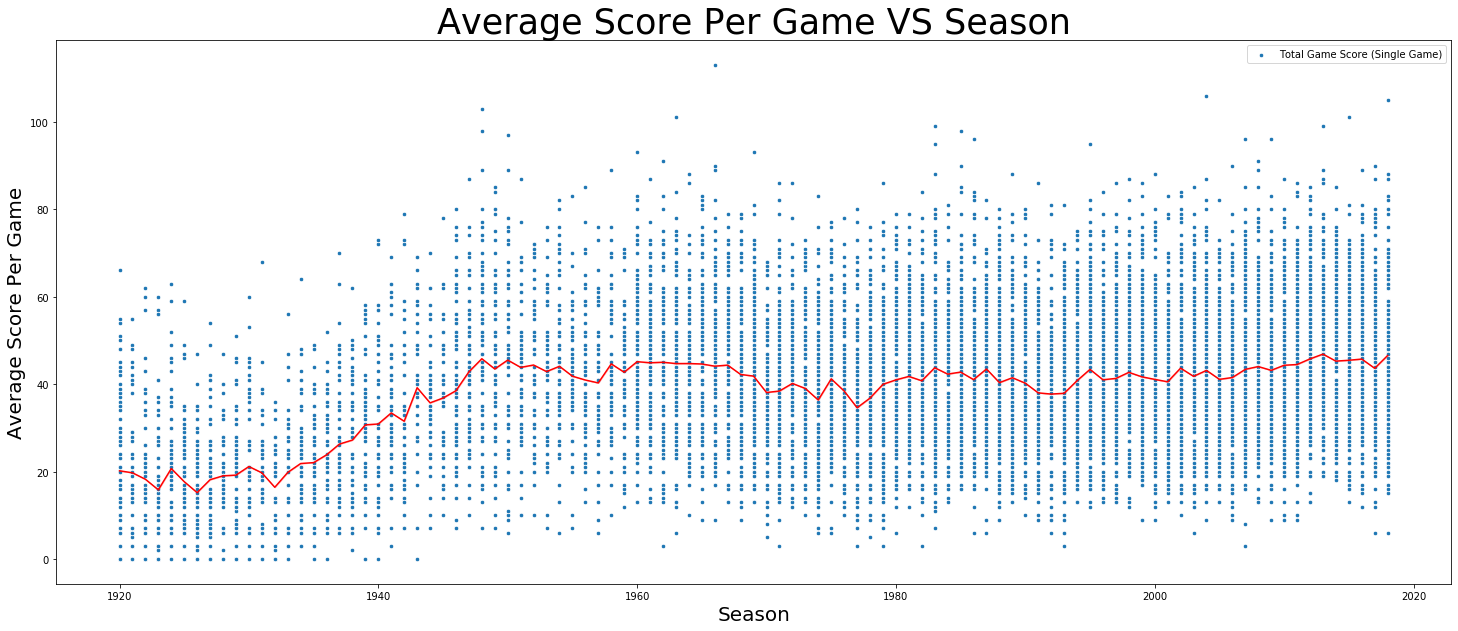

In [9]:
fig = plt.figure(figsize = (25, 10))
ax = sns.scatterplot(x=avgScoreByDate.season, y="totalScore", data=avgScoreByDate, zorder=1, s=20, label='Total Game Score (Single Game)')
ax = sns.lineplot(x=avgScoreByDate.season, y="seasonMean", data=avgScoreByDate, zorder=3, color='red', ci=95, ax=ax)
ax.legend()
plt.title('Average Score Per Game VS Season', fontsize=35)
plt.ylabel('Average Score Per Game', fontsize=20)
plt.xlabel('Season', fontsize=20);


The lot shows that the average trends up until 1950 and then it trends sideways<br>
We can drop all data before 1950 and that will allow us to drop date since the average scores by season are more predictable

In [10]:
df = df[df['season'] >= 1950]
df = df.drop(columns=['date'])

# we dont need result either
df = df.drop(columns=['result1'])

df.head()

,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,totalScore,seasonMean
2162,1950,0,0,PHI,CLE,1674.314,1647.304,0.629402,10,35,45,45.506173
2163,1950,0,0,PIT,NYG,1485.849,1461.717,0.625529,7,18,25,45.506173
2164,1950,0,0,LAR,CHI,1564.606,1628.688,0.501321,20,24,44,45.506173
2165,1950,0,0,BCL,WSH,1337.541,1454.448,0.425851,14,38,52,45.506173
2166,1950,0,0,SF,NYY,1589.774,1321.925,0.871695,17,21,38,45.506173


In [11]:
labelEncoder = preprocessing.LabelEncoder()
df['team1'] = labelEncoder.fit_transform(df['team1'])
df['team2'] = labelEncoder.fit_transform(df['team2'])

df.head()

,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,totalScore,seasonMean
2162,1950,0,0,28,8,1674.314,1647.304,0.629402,10,35,45,45.506173
2163,1950,0,0,29,24,1485.849,1461.717,0.625529,7,18,25,45.506173
2164,1950,0,0,19,6,1564.606,1628.688,0.501321,20,24,44,45.506173
2165,1950,0,0,3,34,1337.541,1454.448,0.425851,14,38,52,45.506173
2166,1950,0,0,31,26,1589.774,1321.925,0.871695,17,21,38,45.506173


# Regressions

We will apply some regression models and compare the results

In [12]:
indepVars = df[['season', 'neutral', 'playoff', 'team1', 'team2', 'elo1', 'elo2', 'elo_prob1']]
depVars = df[['score1', 'score2']]

X_train, X_test, Y_train, Y_test = train_test_split(indepVars, depVars, test_size=0.3)

First we try a Random Forest Regressor

In [17]:
# create random forest regressor
regressor = DecisionTreeRegressor()

# train classifier on test data
regressor = regressor.fit(X_train, Y_train)

decisionTreePrediction = regressor.predict(X_test)

In [18]:
print( metrics.r2_score(Y_test, decisionTreePrediction) )

-0.8597914638463046


In [19]:
print( metrics.r2_score(Y_train, regressor.predict(X_train), multioutput = 'variance_weighted'))

1.0


As we can see the model is overfitted on the train (1.0), so it doesn't know what to do when it gets new testing data

In [13]:
regressor = RandomForestRegressor(n_estimators = 200)
regressor.fit(X_train, Y_train)
randomForestPrediction = regressor.predict(X_test)

In [14]:
print( metrics.r2_score(Y_test, randomForestPrediction) )

0.04742168452524986


In [15]:
print( metrics.r2_score(Y_train, regressor.predict(X_train), multioutput = 'variance_weighted'))

0.8679119123887378


This has less of an overfitting problem but it still isnt great. It isn't 1.0, though, so it is clearly the better choice